In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from PIL import Image

In [3]:
data_directory = 'C:/Users/Wonder-David Efe/Videos/segmented_reduced'
image_size = (224, 224)

# Get the list of class directories
class_directories = os.listdir(data_directory)

images = []
labels = []

# Iterate over the class directories
for i, class_dir in enumerate(class_directories):
    class_path = os.path.join(data_directory, class_dir)
    
    # Get the list of image files in the class directory
    image_files = os.listdir(class_path)
    
    # Iterate over the image files
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        
        # Open and resize the image
        image = Image.open(image_path)
        image = image.resize(image_size)
        
        # Convert the image to a numpy array
        image_array = np.array(image)
        
        # Append the image array and corresponding label to the lists
        images.append(image_array)
        labels.append(i)  # Use the class index as the label

# Convert the image and label lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images from {len(class_directories)} classes.")
print("Image shape:", images.shape)
print("Label shape:", labels.shape)


Loaded 1000 images from 2 classes.
Image shape: (1000, 224, 224)
Label shape: (1000,)


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
x_trainval, x_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=42)


In [5]:
# # what does this line mean???
img_size =224
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_train = x_train.repeat(3, axis=-1)

x_val = x_val.reshape(-1, img_size, img_size, 1)
x_val = x_val.repeat(3, axis=-1)

y_train = np.array(y_train)
y_val = np.array(y_val)


In [6]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255


In [7]:
#Data augmentation on the train data:-
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range = 50, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip = True, # randomly flip images
    vertical_flip=False,# randomly flip images
    validation_split=0.2) 


datagen.fit(x_train)

In [8]:
base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3),
                                                    include_top=False,
                                                    weights='imagenet')


58889256/58889256 [==============================] - 9s 0us/step


In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14,846,530
Trainable params: 14,846,530
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [13]:
# datagen = ImageDataGenerator(horizontal_flip=True, fill_mode='nearest')
train_generator = datagen.flow_from_directory(data_directory, target_size=(224, 224), 
                                              class_mode='categorical',
                                              subset='training')

validation_generator = datagen.flow_from_directory(data_directory, target_size=(224, 224),
                                                   class_mode='categorical',
                                                   subset='validation')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
history = model.fit(train_generator, epochs=1, validation_data=validation_generator)

25/25 [==============================] - 1242s 49s/step - loss: 2.1041 - accuracy: 0.4938 - val_loss: 0.7065 - val_accuracy: 0.5000


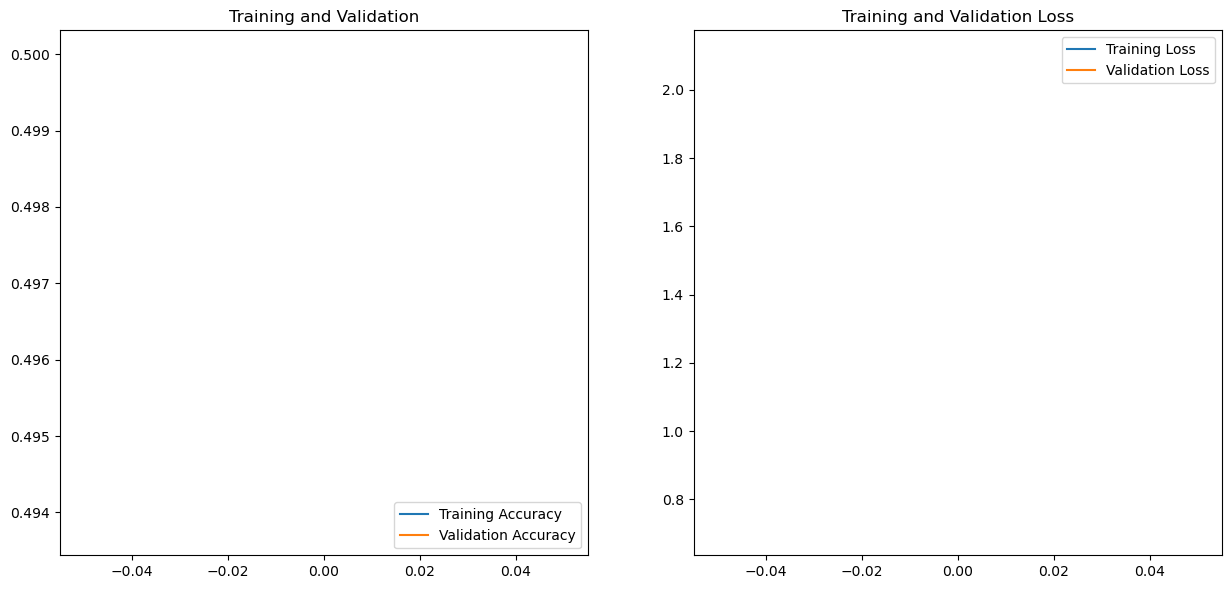

In [17]:
# Evaluating the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
Y_pred = model.predict(validation_generator) #Y_pred = model.predict_generator(test_generator, batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

7/7 [==============================] - 6s 645ms/step


In [16]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print(cf_matrix);
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred))


Confusion Matrix
[[  1  99]
 [  0 100]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       100
           1       0.50      1.00      0.67       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200

